In [4]:
# Mawrer Amed Ramirez Martinez
# Avance de TOG IDI 4
# ms723737@iteso.mx
# mawrer@gmail.com

import numpy as np
np.random.seed(1)
import tensorflow as tf
tf.random.set_seed(2)

from keras import backend as K

from statsmodels.tsa.arima_model import ARIMA

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pyplot import figure

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import tensorflow as tf 
from keras import metrics
from keras.callbacks import ModelCheckpoint

import pandas as pd 
import math as m
import os, glob

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [75]:
ID = "02"
MODEL_NAME = "LSTM"
NUM_FEATURES = 0
TARGET_NAME = "Close"
FRECUENCIA = "1D"
MSE_RESULT = 0

In [9]:
RANGE = 51

HYPER_L1_IN = RANGE
EPOCHS = 100
BATCH_SIZE = 32

TEST_SIZE = .2
VAL_SIZE = .2

START_IN = 0

TRAINING_TIME_ELAPSED = 0

TRAIN_MSE=0
TRAIN_RMSE=0
TRAIN_MAE=0
TEST_MSE=0
TEST_RMSE=0
TEST_MAE=0


In [10]:
pwd = os.getcwd()
datasource_path = os.path.join(pwd, r'../../../Datasets/Junio2020/procesados/')
filenames = glob.glob(datasource_path + "/*.csv")
filenames.sort()
for file in filenames:
    print(os.path.basename(file))

EURUSD_ASK_1H_14F.csv
EURUSD_FULL_1D_20F.csv
EURUSD_FULL_1H_20F.csv
EURUSD_FULL_1M_20F.csv
EURUSD_FULL_4H_20F.csv


In [12]:
if FRECUENCIA =="1D":
    dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
else:
    dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

DATASET = pd.read_csv(filenames[1], header=0, parse_dates=['Gmt time'], date_parser=dateparse)
DATASET.head()


,Gmt time,Open,High,Low,Close,Volume,Open_Bid,High_Bid,Low_Bid,Close_Bid,Volume_Bid,Spread,day_name,weekday,Pct_Range_Close,Pct_Range_Close_diff,MA_Close_5,MA_Close_25,MA_Close_50,MA_Close_200
0,2004-01-01,1.25950,1.26052,1.24698,1.25733,4.621817e+05,1.25934,1.26035,1.24679,1.25723,5.597896e+05,0.00010,Thursday,3,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,2004-01-02,1.25717,1.26282,1.25214,1.25832,1.066578e+06,1.25701,1.26263,1.25198,1.25806,1.277971e+06,0.00026,Friday,4,0.000787,0.000787,0.000000,0.0,0.0,0.0
2,2004-01-04,1.25925,1.26487,1.25789,1.26318,6.879980e+04,1.25855,1.26477,1.25779,1.26308,8.372040e+04,0.00010,Sunday,6,0.003862,0.003075,0.000000,0.0,0.0,0.0
3,2004-01-05,1.26324,1.26935,1.26301,1.26830,1.119689e+06,1.26308,1.26924,1.26288,1.26820,1.353480e+06,0.00010,Monday,0,0.004053,0.000191,0.000000,0.0,0.0,0.0
4,2004-01-06,1.26836,1.28093,1.26666,1.27150,1.125442e+06,1.26820,1.28083,1.26650,1.27140,1.354807e+06,0.00010,Tuesday,1,0.002523,-0.001530,1.263726,0.0,0.0,0.0


In [13]:
#Describe DATASET
print('Shape: ', DATASET.shape)
print(DATASET.describe())

#Remove Day_name Column and Timestamp
DATASET = DATASET.drop(['day_name'], axis = 1)
DATASET = DATASET.drop(['Gmt time'], axis = 1)
print(DATASET.dtypes)


Shape:  (5137, 20)
              Open         High          Low        Close        Volume  \
count  5137.000000  5137.000000  5137.000000  5137.000000  5.137000e+03   
mean      1.263948     1.268773     1.259111     1.263939  4.156849e+05   
std       0.122827     0.123592     0.121990     0.122823  4.429918e+05   
min       1.039090     1.041820     1.034050     1.039090  5.400000e+01   
25%       1.149190     1.153490     1.145380     1.149120  1.159636e+05   
50%       1.270260     1.275990     1.265560     1.270260  2.200810e+05   
75%       1.350610     1.355180     1.345920     1.350700  7.439951e+05   
max       1.597400     1.604030     1.589800     1.597370  2.237468e+06   

          Open_Bid     High_Bid      Low_Bid    Close_Bid    Volume_Bid  \
count  5137.000000  5137.000000  5137.000000  5137.000000  5.137000e+03   
mean      1.263810     1.268680     1.259015     1.263822  4.616911e+05   
std       0.122817     0.123571     0.121969     0.122813  5.305200e+05   
min  

In [16]:
#Remove first 200 rows because MA200 is 0
DF_Full = DATASET[199:]
DF_Full.reset_index(drop=True, inplace=True)
print(DF_Full.shape)
print(DF_Full.head())

(4938, 18)
      Open     High      Low    Close        Volume  Open_Bid  High_Bid  \
0  1.23655  1.23817  1.22801  1.23179  1.078729e+06   1.23639   1.23804   
1  1.23158  1.23241  1.22967  1.23109  8.212280e+04   1.23088   1.23231   
2  1.23140  1.23154  1.21310  1.21496  1.130388e+06   1.23124   1.23140   
3  1.21495  1.21669  1.20594  1.20711  1.123270e+06   1.21479   1.21656   
4  1.20718  1.21160  1.20519  1.20794  1.118725e+06   1.20702   1.21156   

   Low_Bid  Close_Bid   Volume_Bid  Spread  weekday  Pct_Range_Close  \
0  1.22791    1.23169  1291823.750  0.0001        4        -0.003680   
1  1.22955    1.23099    93508.000  0.0001        6        -0.000568   
2  1.21298    1.21486  1348137.000  0.0001        0        -0.013102   
3  1.20583    1.20701  1344214.000  0.0001        1        -0.006461   
4  1.20504    1.20784  1355827.375  0.0001        2         0.000688   

   Pct_Range_Close_diff  MA_Close_5  MA_Close_25  MA_Close_50  MA_Close_200  
0             -0.005690    

In [15]:
#Shape 
total = DF_Full.shape[0]
print('Total: ', total)
print('Start: ', START_IN)

Total:  4938
Start:  0


In [27]:
#Shape the first START of the total and Number of Features
DF_Full = DF_Full.iloc[START_IN:]
DF_Full.reset_index(drop=True, inplace=True) #reset indexes from iloc
print(DF_Full.shape)

NUM_FEATURES = DF_Full.shape[1]
print("NUM_FEATURES = ",NUM_FEATURES)

(4938, 18)
NUM_FEATURES =  18


In [29]:
#VECTOR Y
TARGET_INDEX = DF_Full.columns.get_loc(TARGET_NAME)
print("index column: ",TARGET_INDEX)
print('VECTOR Y: ' + DF_Full[TARGET_NAME].name)
close_y = DF_Full[TARGET_NAME].iloc[1:]
close_y.columns = [TARGET_NAME+'_y']
print(close_y.head())
print(close_y.shape)
close_y = close_y.append(close_y.tail(1), ignore_index=True)
print(close_y.tail())
print(close_y.shape)

index column:  3
VECTOR Y: Close
1    1.23109
2    1.21496
3    1.20711
4    1.20794
5    1.21079
Name: Close, dtype: float64
(4937,)
4933    1.10169
4934    1.10782
4935    1.11071
4936    1.11158
4937    1.11158
Name: Close, dtype: float64
(4938,)


In [30]:
#Define INDEX for Subsets for Training, Testing and Validation

s1 = TEST_SIZE + VAL_SIZE
print('Sum of %s:',s1)
f1 = int(total * s1)
print('count of Val and Test:',f1)
end_train = total - f1
print('end of train: ', end_train)

count_val= int(total * VAL_SIZE)
print('count val: ',count_val)

count_test= int(total * TEST_SIZE)
print('count test: ',count_test)


end_val = end_train + count_val
print('end_val', end_val)



Sum of %s: 0.4
count of Val and Test: 1975
end of train:  2963
count val:  987
count test:  987
end_val 3950


In [32]:
#Generate Subsets for Training, Testing and Validation
data_training = DF_Full.iloc[:end_train]
data_val = DF_Full.iloc[end_train: end_val]
data_test = DF_Full.iloc[end_val:]

print(data_training.shape)
print(data_val.shape)
print(data_test.shape)


#For Target Y Vector
data_training_y = close_y.iloc[:end_train]
data_val_y = close_y.iloc[end_train: end_val]
data_test_y = close_y.iloc[end_val:]

print(data_training_y.shape)
print(data_val_y.shape)
print(data_test_y.shape)

(2963, 18)
(987, 18)
(988, 18)
(2963,)
(987,)
(988,)


In [33]:
# DATA SET SCALER TRAINING
scaler = MinMaxScaler(feature_range=(0, 1))
#print(data_training.head)
data_training_array = np.array(data_training)
data_training_array_scaled = scaler.fit_transform(data_training_array)
print(data_training_array_scaled)
    

[[0.16128208 0.15335663 0.14996946 ... 0.10884013 0.11249812 0.07491445]
 [0.14973038 0.14002731 0.15386965 ... 0.11100309 0.11323194 0.07452118]
 [0.14931201 0.13801402 0.11493821 ... 0.11143825 0.11307661 0.07387132]
 ...
 [0.42206675 0.4204059  0.43127673 ... 0.45902053 0.47705178 0.42738973]
 [0.43031796 0.42112327 0.43508294 ... 0.45789504 0.47606665 0.42763133]
 [0.42869096 0.42503413 0.43637517 ... 0.45707021 0.47501702 0.42788821]]


(2963, 18)


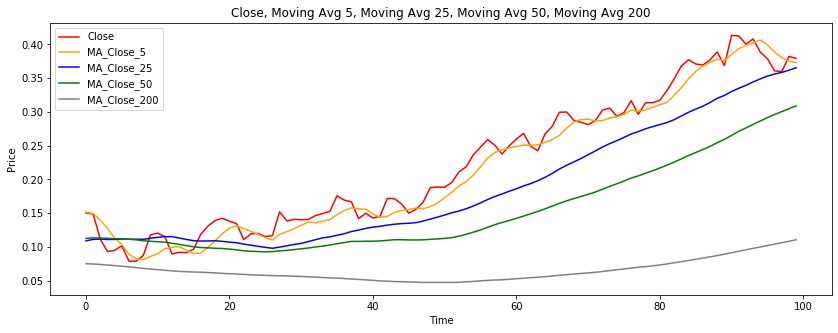

In [37]:
INICIO = 0
FIN = 100

IDX_Close = DF_Full.columns.get_loc("Close")
IDX_MA_Close_5 = DF_Full.columns.get_loc("MA_Close_5")
IDX_MA_Close_25 = DF_Full.columns.get_loc("MA_Close_25")
IDX_MA_Close_50 = DF_Full.columns.get_loc("MA_Close_50")
IDX_MA_Close_200 = DF_Full.columns.get_loc("MA_Close_200")

print(data_training_array_scaled.shape)
plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_5], color = 'orange', label = 'MA_Close_5')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_25], color = 'blue', label = 'MA_Close_25')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_50], color = 'green', label = 'MA_Close_50')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_200], color = 'gray', label = 'MA_Close_200')
plt.title('Close, Moving Avg 5, Moving Avg 25, Moving Avg 50, Moving Avg 200')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

(2963, 18)


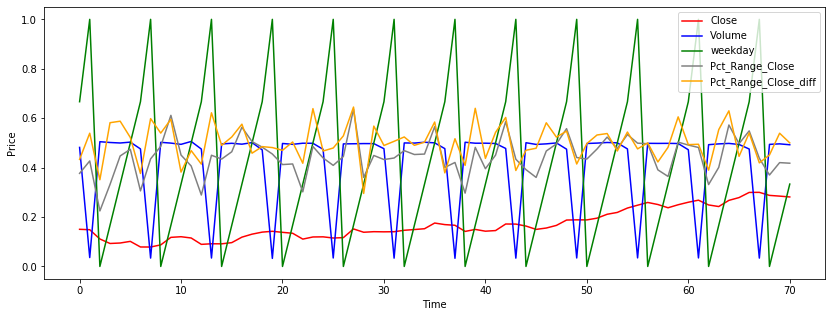

In [39]:
print(data_training_array_scaled.shape)
INICIO = 0
FIN = 71


IDX_Close = DF_Full.columns.get_loc("Close")
IDX_Volume = DF_Full.columns.get_loc("Volume")
IDX_weekday = DF_Full.columns.get_loc("weekday")
IDX_Pct_Range_Close = DF_Full.columns.get_loc("Pct_Range_Close")
IDX_Pct_Range_Close_diff = DF_Full.columns.get_loc("Pct_Range_Close_diff")

plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Volume], color = 'blue', label = 'Volume')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_weekday], color = 'green', label = 'weekday')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Pct_Range_Close], color = 'gray', label = 'Pct_Range_Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Pct_Range_Close_diff], color = 'orange', label = 'Pct_Range_Close_diff')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

(2963, 18)


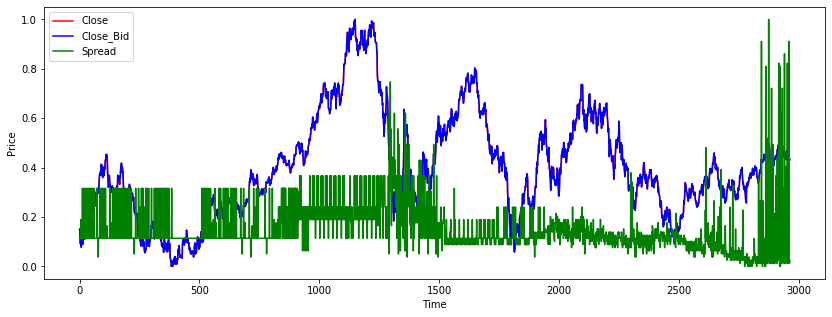

In [41]:
print(data_training_array_scaled.shape)
INICIO = 0
FIN = 2963


IDX_Close = DF_Full.columns.get_loc("Close")
IDX_Close_Bid = DF_Full.columns.get_loc("Close_Bid")
IDX_Spread = DF_Full.columns.get_loc("Spread")

plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close_Bid], color = 'blue', label = 'Close_Bid')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Spread], color = 'green', label = 'Spread')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

(2963, 18)


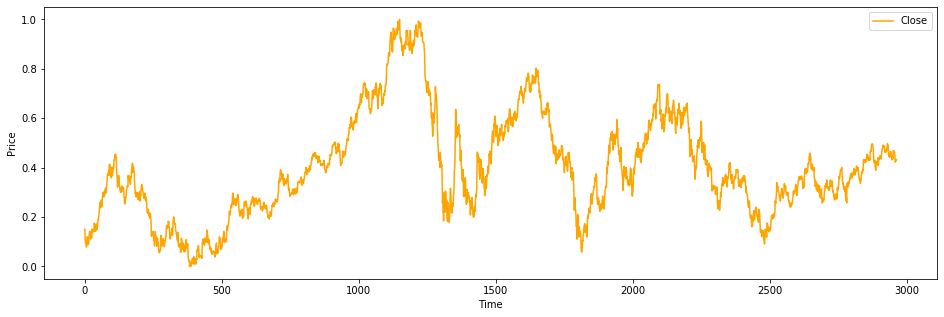

In [48]:
print(data_training_array_scaled.shape)
INICIO = 0
FIN = 10377
plt.figure(figsize=(16,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,TARGET_INDEX], color = 'orange', label = TARGET_NAME)
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

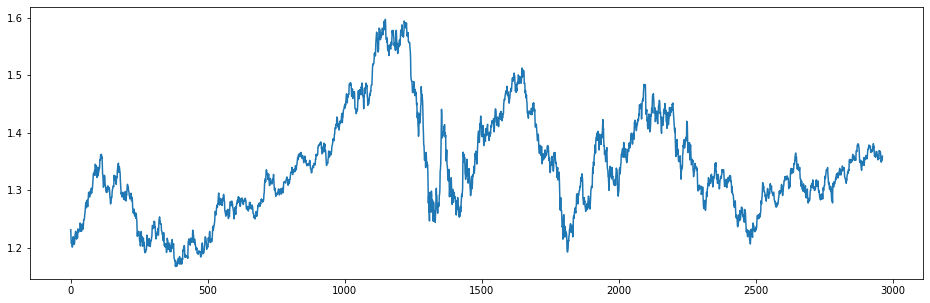

In [46]:
pyplot.figure(figsize=(16,5))
pyplot.plot(data_training_y)

In [49]:
X_train = []
y_train = []
for i in range(RANGE, data_training_array_scaled.shape[0]):
    X_train.append(data_training_array_scaled[i-RANGE:i])
    y_train.append(data_training_y[i])

X_train_np, y_train_np = np.array(X_train), np.array(y_train)

print(X_train_np.shape)
print(y_train_np.shape)

(2912, 51, 18)
(2912,)


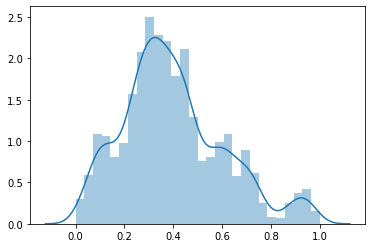

In [50]:
sns.distplot(data_training_array_scaled[INICIO:FIN,TARGET_INDEX]);


In [51]:

#Obtener los ultimos valores de Train para agregarlos a Val DF
# APPEND DE X
last_range_training_x = data_training.tail(RANGE)
print(last_range_training_x.shape)
print(data_val.shape)
data_val_x1 = last_range_training_x.append(data_val, ignore_index = True)
data_val_x1.shape
print(data_val_x1.head)

(51, 18)
(987, 18)
<bound method NDFrame.head of          Open     High      Low    Close       Volume  Open_Bid  High_Bid  \
0     1.37066  1.37471  1.36946  1.37374  153247.4688   1.37064   1.37457   
1     1.37372  1.37955  1.37344  1.37646  195586.4531   1.37370   1.37948   
2     1.37646  1.38110  1.37411  1.37854  185280.8906   1.37641   1.38107   
3     1.37855  1.38033  1.37380  1.37499  210793.7969   1.37850   1.38032   
4     1.37500  1.37697  1.37097  1.37455  173793.7656   1.37496   1.37691   
...       ...      ...      ...      ...          ...       ...       ...   
1033  1.08167  1.08269  1.07403  1.07588  173213.3750   1.08162   1.08264   
1034  1.07588  1.07683  1.06724  1.06879  166713.5000   1.07582   1.07679   
1035  1.06881  1.07020  1.06522  1.06561  185265.9219   1.06875   1.07018   
1036  1.06666  1.06741  1.06590  1.06697    8386.2197   1.06594   1.06737   
1037  1.06697  1.06813  1.06426  1.06701  170208.7656   1.06692   1.06809   

      Low_Bid  Close_Bid  

In [52]:
#Append de los datos de Train al DF de Val en Y
last_range_train_y = data_training_y.tail(RANGE)
print(last_range_train_y.shape)
print(data_val_y.shape)
data_val_y1 = last_range_train_y.append(data_val_y, ignore_index = True)
data_val_y1.shape
print(data_val_y1.head(10))

(51,)
(987,)
0    1.37646
1    1.37854
2    1.37499
3    1.37455
4    1.37382
5    1.37611
6    1.37695
7    1.36826
8    1.36558
9    1.36768
Name: Close, dtype: float64


In [53]:
data_val_x2 = scaler.transform(data_val_x1)
data_val_x2.shape
print(data_val_x2[:10])

[[4.72991819e-01 4.69326360e-01 4.82308162e-01 4.80220342e-01
  6.77819909e-02 4.73361227e-01 4.69387755e-01 4.82679201e-01
  4.80426798e-01 5.70097100e-02 3.79746835e-02 0.00000000e+00
  4.71863988e-01 5.28749209e-01 4.70804455e-01 4.46044766e-01
  4.56943605e-01 3.83564611e-01]
 [4.80104128e-01 4.80526693e-01 4.91659227e-01 4.86542395e-01
  8.67191204e-02 4.80474198e-01 4.80748762e-01 4.92103408e-01
  4.86749733e-01 7.05671070e-02 3.79746835e-02 1.66666667e-01
  4.68026093e-01 4.98923644e-01 4.79360451e-01 4.49574530e-01
  4.58022653e-01 3.84623778e-01]
 [4.86472666e-01 4.84113577e-01 4.93233401e-01 4.91376906e-01
  8.21097096e-02 4.86773594e-01 4.84427785e-01 4.93560517e-01
  4.91561672e-01 6.89428461e-02 5.06329114e-02 3.33333333e-01
  4.60460411e-01 4.96142524e-01 4.84929019e-01 4.53011326e-01
  4.59203362e-01 3.85711271e-01]
 [4.91330420e-01 4.82331706e-01 4.92505051e-01 4.83125697e-01
  9.35209709e-02 4.91631799e-01 4.82692397e-01 4.92737955e-01
  4.83355805e-01 7.53922617e-02 2

In [54]:
X_val = []
y_val = []
for i in range(RANGE, data_val_x2.shape[0]):
    X_val.append(data_val_x2[i-RANGE:i])
    y_val.append(data_val_y1[i])

X_val_np = np.array(X_val)
y_val_np = np.array(y_val)
print(X_val_np.shape)
print(y_val_np.shape)

(987, 51, 18)
(987,)


In [55]:

#Obtener los ultimos valores de Val para agregarlos a TEST DF
# Append en X
last_range_data_training_x = data_training.tail(RANGE)
print(last_range_data_training_x.shape)
print(data_test.shape)
data_test_x1 = last_range_data_training_x.append(data_test, ignore_index = True)
data_test_x1.shape


(51, 18)
(988, 18)


(1039, 18)

In [56]:
#Append de los datos de Val al DF de Test de Y
last_range_training_y = data_training_y.tail(RANGE)
print(last_range_training_y.shape)
print(data_test_y.shape)
data_test_y1 = last_range_training_y.append(data_test_y, ignore_index = True)
data_test_y1.shape

(51,)
(988,)


(1039,)

In [57]:
data_test_x2 = scaler.transform(data_test_x1)
data_test_x2.shape
print(data_test_x2[:10])

[[4.72991819e-01 4.69326360e-01 4.82308162e-01 4.80220342e-01
  6.77819909e-02 4.73361227e-01 4.69387755e-01 4.82679201e-01
  4.80426798e-01 5.70097100e-02 3.79746835e-02 0.00000000e+00
  4.71863988e-01 5.28749209e-01 4.70804455e-01 4.46044766e-01
  4.56943605e-01 3.83564611e-01]
 [4.80104128e-01 4.80526693e-01 4.91659227e-01 4.86542395e-01
  8.67191204e-02 4.80474198e-01 4.80748762e-01 4.92103408e-01
  4.86749733e-01 7.05671070e-02 3.79746835e-02 1.66666667e-01
  4.68026093e-01 4.98923644e-01 4.79360451e-01 4.49574530e-01
  4.58022653e-01 3.84623778e-01]
 [4.86472666e-01 4.84113577e-01 4.93233401e-01 4.91376906e-01
  8.21097096e-02 4.86773594e-01 4.84427785e-01 4.93560517e-01
  4.91561672e-01 6.89428461e-02 5.06329114e-02 3.33333333e-01
  4.60460411e-01 4.96142524e-01 4.84929019e-01 4.53011326e-01
  4.59203362e-01 3.85711271e-01]
 [4.91330420e-01 4.82331706e-01 4.92505051e-01 4.83125697e-01
  9.35209709e-02 4.91631799e-01 4.82692397e-01 4.92737955e-01
  4.83355805e-01 7.53922617e-02 2

In [58]:
X_test = []
y_test = []
for i in range(RANGE, data_test_x2.shape[0]):
    X_test.append(data_test_x2[i-RANGE:i])
    y_test.append(data_test_y1[i])

X_test_np = np.array(X_test)
y_test_np = np.array(y_test)
print(X_test_np.shape)
print(y_test_np.shape)

(988, 51, 18)
(988,)


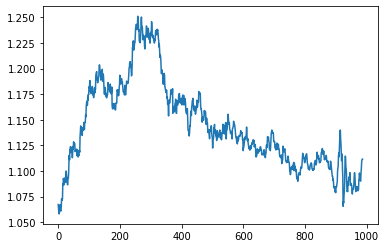

In [59]:
# Y del dataset de pruebas
pyplot.plot(y_test_np)

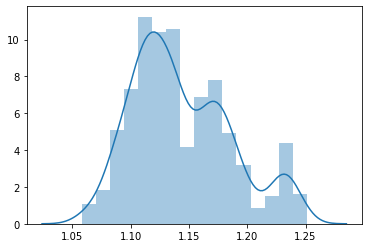

In [60]:
sns.distplot(y_test_np);


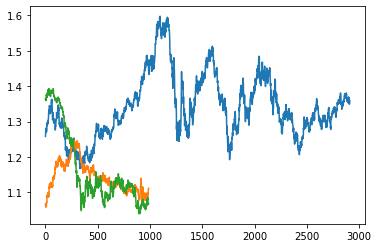

In [63]:

# Y de Val y Test comparados
pyplot.plot(y_train_np)
pyplot.plot(y_test_np)
pyplot.plot(y_val_np)


In [64]:
x_shape = X_train_np.shape[1]
print(x_shape)
y_shape = X_train_np.shape[2]
print(y_shape)

51
18


In [65]:
regressior = Sequential()

regressior.add(LSTM(units = RANGE, activation = 'relu', return_sequences = True, input_shape = (x_shape, y_shape)))
#regressior.add(Dropout(0.2))
regressior.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
#regressior.add(Dropout(0.2))
regressior.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
#regressior.add(Dropout(0.2))
regressior.add(LSTM(units = 120, activation = 'relu'))
#regressior.add(Dropout(0.2))
regressior.add(Dense(units = 1))

In [66]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [67]:
regressior.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'])

In [68]:
regressior.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 51, 51)            14280     
_________________________________________________________________
lstm_1 (LSTM)                (None, 51, 60)            26880     
_________________________________________________________________
lstm_2 (LSTM)                (None, 51, 80)            45120     
_________________________________________________________________
lstm_3 (LSTM)                (None, 120)               96480     
_________________________________________________________________
dense (Dense)                (None, 1)                 121       
Total params: 182,881
Trainable params: 182,881
Non-trainable params: 0
_________________________________________________________________


In [69]:
pwd = os.getcwd()
source_data = os.path.join(pwd, r'../../../Models/2020/LSTM/')
print(source_data)

/Users/marami3/Documents/ITESO/IDI4/forex_prediction/Jupyter Notebooks/IDI4/models/../../../Models/2020/LSTM/


In [70]:
#Model check pointer para almacenar el modelo cada epoca
checkpointer = ModelCheckpoint(filepath=source_data + '/model-{epoch:02d}.hdf5', verbose=1)

In [71]:
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[checkpointer])
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np))
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np), callbacks=[checkpointer], shuffle=True)
history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np),shuffle=True)
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE)



Epoch 1/100
30/91 [========>.....................] - ETA: 5s - loss: 14.1138 - mean_squared_error: 14.1138 - mean_absolute_error: 0.9627 - mean_absolute_percentage_error: 71.0736 - cosine_proximity: 1.0000

KeyboardInterrupt: 

In [74]:
file_name = MODEL_NAME + '_' + FRECUENCIA + '_' + str(NUM_FEATURES) + 'F_' + TARGET_NAME + "_"+ ID + '.hdf5'
print(file_name)
regressior.save(source_data + file_name)

LSTM_1D_18F_Close_02.hdf5


In [75]:
print(history.history.keys())

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'])


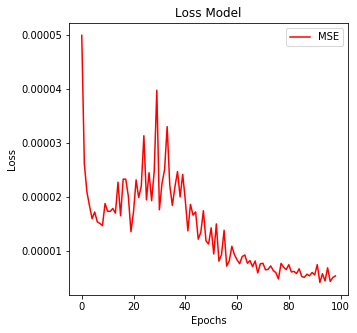

In [76]:
#PLOT MSE MAE
plt.figure(figsize=(5,5))
#plt.plot(history.history['val_loss'][1:], color = 'blue', label = 'Val_Loss')
plt.plot(history.history['mean_squared_error'][1:], color = 'red', label = 'MSE')
#plt.plot(history.history['mean_absolute_error'][1:], color = 'blue', label = 'MAE')
plt.title('Loss Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

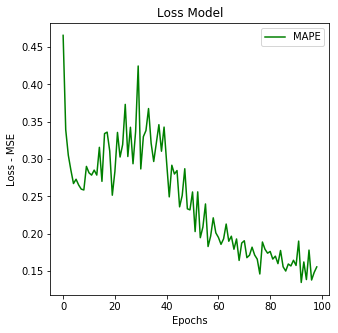

In [77]:
#PLOT MSE MAE
plt.figure(figsize=(5,5))
plt.plot(history.history['mean_absolute_percentage_error'][1:], color = 'green', label = 'MAPE')
plt.title('Loss Model')
plt.xlabel('Epochs')
plt.ylabel('Loss - MSE')
plt.legend()
plt.show()


In [9]:
#Load Model
filepath = os.path.join(source_data, file_name)
print(filepath)
model = tf.keras.models.load_model(filepath)

/Users/marami3/Documents/ITESO/IDI4/forex_prediction/Jupyter Notebooks/IDI4/models/../../../Models/2020/LSTM/
/Users/marami3/Documents/ITESO/IDI4/forex_prediction/Jupyter Notebooks/IDI4/models/../../../Models/2020/LSTM/LSTM_28Jun.hdf5
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [43]:
y_test_pred = model.predict(X_test_np)
y_test_pred.shape



(2816, 1)

In [67]:
numpy_data = np.array(y_test_pred)
yhat = pd.DataFrame(data=numpy_data, columns=["Prediction"])
print(yhat)
#data_test['prediction'] = yhat
#print(data_test.tail)

      Prediction
0       1.115990
1       1.116495
2       1.116815
3       1.116937
4       1.116967
...          ...
2811    1.111904
2812    1.112071
2813    1.112885
2814    1.113827
2815    1.113779

[2816 rows x 1 columns]


In [44]:
y_train_pred = model.predict(X_train_np)
y_train_pred.shape


(11957, 1)

(2816,)
(2816, 1)


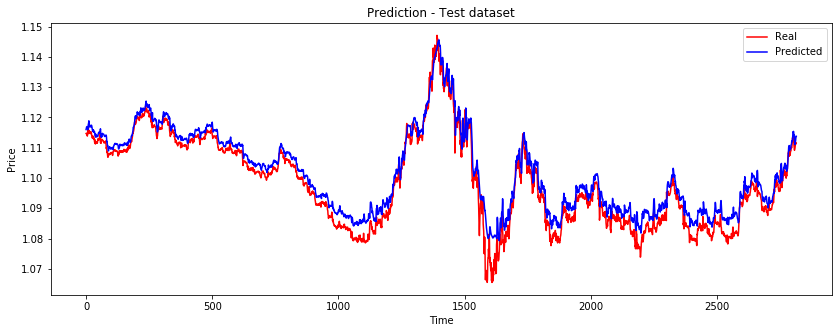

In [45]:
INICIO = 0
FIN = 2816
print(y_test_np.shape)
print(y_test_pred.shape)
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test_np[INICIO:FIN], color = 'red', label = 'Real')
plt.plot(y_test_pred[INICIO:FIN], color = 'blue', label = 'Predicted')
plt.title('Prediction - Test dataset')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [62]:
print(data_test.head)

<bound method NDFrame.head of           Open     High      Low    Close      Volume  weekday  \
12008  1.11394  1.11449  1.11393  1.11444   2497.1201        1   
12009  1.11444  1.11480  1.11444  1.11470   2773.1299        1   
12010  1.11471  1.11494  1.11454  1.11476   2325.7100        1   
12011  1.11474  1.11495  1.11467  1.11476   2848.2200        1   
12012  1.11475  1.11483  1.11419  1.11461   3823.7300        1   
...        ...      ...      ...      ...         ...      ...   
14819  1.10998  1.11070  1.10862  1.10998  12120.8398        4   
14820  1.10997  1.11094  1.10982  1.11071   4646.7427        4   
14821  1.11213  1.11217  1.11136  1.11141    417.4906        6   
14822  1.11138  1.11148  1.11028  1.11123   4549.1167        6   
14823  1.11123  1.11199  1.11119  1.11158   5159.8101        6   

       Pct_Range_Close  Pct_Range_Close_diff  MA_Close_5  MA_Close_25  \
12008         0.000449              0.000260    1.113920     1.114065   
12009         0.000233         

In [46]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [47]:
print('Test MAE:', mean_absolute_error(y_test_np, y_test_pred))#Mean Absolute Error
print('Test RMSE:',np.sqrt(mean_squared_error(y_test_np, y_test_pred)))#Root Mean Squared Error
print('Test MSE:',mean_squared_error(y_test_np, y_test_pred))#Mean Squared Error
print('Test MAPE:',mean_absolute_percentage_error(y_test_np, y_test_pred))#Mean Absolute Percentaje Error


Test MAE: 0.0033898667912727067
Test RMSE: 0.004065391960968254
Test MSE: 1.6527411796305307e-05
Test MAPE: 1.476808826409606


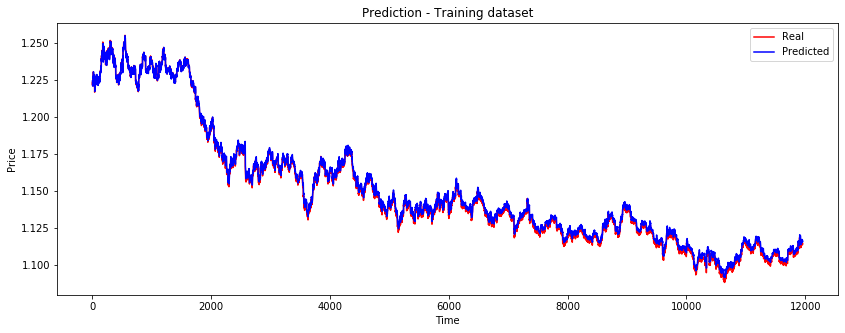

In [48]:

# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_train_np, color = 'red', label = 'Real')
plt.plot(y_train_pred, color = 'blue', label = 'Predicted')
plt.title('Prediction - Training dataset')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [50]:
print('Train MAE:', mean_absolute_error(y_train_np, y_train_pred))#Mean Absolute Error
print('Train RMSE:',np.sqrt(mean_squared_error(y_train_np, y_train_pred)))#Root Mean Squared Error
print('Train MSE:',mean_squared_error(y_train_np, y_train_pred))#Mean Squared Error
print('Test MAPE:',mean_absolute_percentage_error(y_train_np, y_train_pred))#Mean Absolute Percentaje Error


Train MAE: 0.0018078505081128267
Train RMSE: 0.002128351474058285
Train MSE: 4.529879997126075e-06
Test MAPE: 3.820683267562002


In [51]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover, SignalStrategy, TrailingStrategy

Loading BokehJS ...

In [ ]:
class LSTM(Strategy):
    def init(self):
        Close = self.data.Close
        Prediction = self.data.

    def next(self):
        if crossover(self.ma1, self.ma2):
            self.buy()
        elif crossover(self.ma2, self.ma1):
            self.sell()

In [ ]:
bt = Backtest(DATASET, SmaCross, cash=1000, commission=.001)
bt.run()